<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

Привет! Спасибо, что вовремя сдал задание:) Ты проделал большую работу. Далее в файле мои комментарии ты сможешь найти в ячейках, аналогичных данной. Не удаляй эти комментарии и постарайся учесть их в ходе выполнения проекта.

</div>

## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
import matplotlib.pyplot as plt

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
data = pd.read_csv('/datasets/data.csv')
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
None
   children  days_employed  dob_years education  education_id  \
0         1   -8437.673028         42    высшее             0   
1         1   -4024.803754         36   среднее             1   
2         0   -5623.422610         33   Среднее             1   
3         3   -4124.747207         32   среднее             1  

### Вывод

При выводе общей информации о таблице, обнаружились два столбца (`'days_employed'` и `'total_income'`) с отсутствующими значениями. Также обнаружились отрицательные значения в столбце с трудовым стажем.

<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

Отличное начало. Так же для большего понимания данных можно было использовать команду `describe`

</div>

### Шаг 2. Предобработка данных

### Обработка пропусков

На предыдущем шаге, при выводе общей информации о таблице, обнаружились два столбца (`'days_employed'` и `'total_income'`) с отсутствующими значениями. Посмотрим, что это за категория людей.

In [3]:
data_zero = data[data['total_income'].isnull()]
print(data_zero['days_employed'].value_counts(dropna=False))


NaN    2174
Name: days_employed, dtype: int64


В обоих столбцах значения пропущены в одних и тех же строках. Посмотрим, какой тип занятости указан у людей с пропусками, и взглянем на процент должников среди них.

In [4]:
print((data_zero.pivot_table(index=['income_type'], values='debt', aggfunc=['mean']).applymap("{0:.1%}".format)))

                 mean
                 debt
income_type          
госслужащий      4.8%
компаньон        5.9%
пенсионер        8.5%
предприниматель  0.0%
сотрудник        8.9%


Рассмотрим, как распределились заявители по видам занятости:

In [5]:
print((data.pivot_table(index=['income_type'], values='gender', aggfunc=['count'])))

                 count
                gender
income_type           
безработный          2
в декрете            1
госслужащий       1459
компаньон         5085
пенсионер         3856
предприниматель      2
сотрудник        11119
студент              1


А теперь взглянем, каким образом заявители распределились в выборке с отсутствующими значениями:

In [6]:
print((data_zero.pivot_table(index=['income_type'], values='gender', aggfunc=['count'])))

                 count
                gender
income_type           
госслужащий        147
компаньон          508
пенсионер          413
предприниматель      1
сотрудник         1105


Выяснили, что в "нулевой" выборке заявители распределились в тех же пропорциях, что и в общей выборке.

Обнаружили, что среди людей с пропусками в информации о доходе - люди работающие и пенсионеры, то есть у всех предполагается доход и стаж. Вероятно, пропуски - результат технической ошибки. Правильно будет заменить отсутствующие значения месячного дохода и трудового стажа на медианные значения по соответствующей группе по типу занятости.

In [7]:
data.fillna('', inplace=True)
def median_income(row):
    if row['total_income'] == '':
        income_type = row['income_type']
        median = data[(data['income_type'] == income_type)&(data['total_income']!='')]['total_income'].median()    
        return median
    else:
        return row['total_income']
    
def median_employed(row):
    if row['days_employed'] == '':
        income_type = row['income_type']
        median = data[(data['income_type'] == income_type)&(data['days_employed']!='')]['days_employed'].median()    
        return median
    else:
        return row['days_employed']
data['total_income']= data.apply(median_income, axis=1)
data['days_employed']=data.apply(median_employed, axis=1)

Проверим успешность замены отсутствующих значений на медианные:

In [8]:
print('Число пустых строк в столбце days_employed ', len(data[data['days_employed'] == '']))
print('Число пустых строк в столбце total_income ', len(data[data['total_income'] == '']))

Число пустых строк в столбце days_employed  0
Число пустых строк в столбце total_income  0


/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Также напрашивается заменить отрицательные значения в столбце трудового стажа на соответсвующие положительные:

In [9]:
data['days_employed'] = abs(data['days_employed'])

### Вывод

Заполнили пропуски в столбцах с доходами и стажем на медианные значения по группам занятости. 

<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

Всё хорошо

</div>

### Замена типа данных

Заменим вещественный тип данных в столбцах `'total_income'` и `'days_employed'` на целочисленный:

In [10]:
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')

Проверим новый тип данных этих столбцов:

In [11]:
print('Тип данных в столбце days_employed: ', data['days_employed'].dtypes)
print('Тип данных в столбце total_income: ', data['total_income'].dtypes)

Тип данных в столбце days_employed:  int64
Тип данных в столбце total_income:  int64


### Вывод

Заменили вещественный тип данных в столбцах `'total_income'` и `'days_employed'` на целочисленный, используя метод `astype()` (он подходит нам, так как при помощи этого метода с аргументом `('int')` мы получим данные в нужном нам типе).

<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

Хорошо

</div>

### Обработка дубликатов

Перед поиском дубликатов выясним, нет ли необходимости приводить текстовую информацию к одному регистру:

In [12]:
def value_output(col):
    print('------------------------------------------------')
    return print(data[col].value_counts())  

value_output('education')
value_output('family_status')
value_output('gender')
value_output('income_type')
value_output('purpose')
value_output('debt')

------------------------------------------------
среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64
------------------------------------------------
женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64
------------------------------------------------
F      14236
M       7288
XNA        1
Name: gender, dtype: int64
------------------------------------------------
сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащ

В приведении к одному регистру нуждается столбец `'education'`. Приведем все значения этого столбца к нижнему регистру и проверим успешность замены:

In [13]:
data['education'] = data['education'].str.lower()
print(data['education'].value_counts())

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64


Теперь можно посчитать количество дубликатов в таблице:

In [14]:
print('Количество дубликатов в таблице', data.duplicated().sum())

Количество дубликатов в таблице 71


Удалим дубликаты, используя метод `drop_duplicates()` в сочетании с методом `reset_index()` для восстановления упорядоченных индексов:

In [15]:
data = data.drop_duplicates().reset_index(drop = True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 12 columns):
children            21454 non-null int64
days_employed       21454 non-null int64
dob_years           21454 non-null int64
education           21454 non-null object
education_id        21454 non-null int64
family_status       21454 non-null object
family_status_id    21454 non-null int64
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null int64
total_income        21454 non-null int64
purpose             21454 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB
None


Число строк в таблице уменьшилось на 71, это были удаленные дубликаты.

### Вывод

В данных присутствовали дубликаты, и были удалены.

<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

Хорошо) Можешь подумать о причинах возникновения дубликатов

</div>

### Лемматизация

Следующим шагом выделим леммы в значениях столбца с целями получения кредита. Для этого воспользуемся библиотекой pymystem3, а именно функцией `.lemmatize`. При помощи функции `.join` склеим элементы list-a, который получили на выходе работы функции `.lemmatize`, и запишем результат как элемент нового столбца `'purpose_lemmatized'`.

In [16]:
m = Mystem()
def purpose_lemmatize(row):
    return ''.join(m.lemmatize(row['purpose'])[:-1])
data['purpose_lemmatized']= data.apply(purpose_lemmatize, axis=1)

print(data['purpose_lemmatized'].value_counts())    
print('Всего заявок ', data['purpose_lemmatized'].value_counts().sum()) 

автомобиль                                972
свадьба                                   791
на проведение свадьба                     768
сыграть свадьба                           765
операция с недвижимость                   675
покупка коммерческий недвижимость         661
операция с жилье                          652
покупка жилье для сдача                   651
операция с коммерческий недвижимость      650
жилье                                     646
покупка жилье                             646
покупка жилье для семья                   638
строительство собственный недвижимость    635
недвижимость                              633
операция со свой недвижимость             627
строительство жилой недвижимость          624
покупка недвижимость                      621
покупка свой жилье                        620
строительство недвижимость                619
ремонт жилье                              607
покупка жилой недвижимость                606
на покупка свой автомобиль        

### Вывод

Создали новый столбец в исходной таблице, куда записали полученные из столбца `'purpose'` леммы. В дальнейшем это поможет в задаче категоризации.

### Категоризация данных

При анализе вывода предыдущего кода можно выделить несколько основных категорий, объединив сходные по смыслу и качеству подкатегории: 
  * 1 - автокредит, 
  * 2 - потребительский кредит, 
  * 3 - образовательный кредит, 
  * 4 - ипотечный кредит. 
  
Присвоим соответсвующий номер каждой из подкатегорий:

<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

Леммы выделены верно, молодец!)

</div>

In [17]:
def purpose_category(row):
    lemmas = m.lemmatize(row['purpose'])
    if lemmas.count('автомобиль') != 0 :
        return 'автокредит'
    if lemmas.count('свадьба') != 0 or lemmas.count('ремонт') != 0:  
        return  'потребительский кредит'
    if lemmas.count('образование') != 0:  
        return 'образовательный кредит'    
    if lemmas.count('жилье') != 0 or lemmas.count('недвижимость') != 0:  
        return 'ипотечный кредит'    
    
data['purpose_category']= data.apply(purpose_category, axis=1)

print(data['purpose_category'].value_counts())    
print('Всего заявок ', data['purpose_category'].value_counts().sum()) 

ипотечный кредит          10204
автокредит                 4306
образовательный кредит     4013
потребительский кредит     2931
Name: purpose_category, dtype: int64
Всего заявок  21454


Ипотечные кредиты - самые популярные, обогнали более чем в два раза автомобильный и образовательный кредиты. Реже всего запрашивают потребительский кредит.

Введем еще одно деление на категории - разделим заемщиков по уровню их дохода. Для начала определим медиану и средее по столбцу с доходами.

In [18]:
print('Медиана доходов {0:.0f}'.format(data['total_income'].median()))
print('Среднее арифметическое доходов {0:.0f}'.format(data['total_income'].mean()))

Медиана доходов 142594
Среднее арифметическое доходов 165320


Взглянем на гистограмму и статистику по столбцу  `'total_income'`:

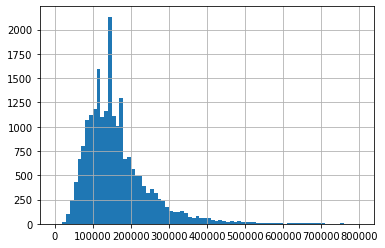

In [19]:
data['total_income'].hist(bins =80, range = (0, 800000))

In [20]:
data_stat = data['total_income'].describe()
print(data_stat.apply(lambda x: format(x, 'f')))

count      21454.000000
mean      165319.572294
std        98187.303486
min        20667.000000
25%       107623.000000
50%       142594.000000
75%       195820.250000
max      2265604.000000
Name: total_income, dtype: object


 Разделим заемщиков, разграничив категории в соответсвии со статистикой по 25, 50 и 75 процентилям:

In [21]:
def income_category(row):
    if 0 < row['total_income'] <=  data_stat['25%'] :
        return 1
    if data_stat['25%'] < row['total_income'] <= data_stat['50%']:
        return 2
    if data_stat['50%'] < row['total_income'] <= data_stat['75%'] :
        return 3    
    if  row['total_income'] > data_stat['75%']:
        return 4  
    
data['income_category']= data.apply(income_category, axis=1)    
print(data['income_category'].value_counts())  

2    5479
4    5364
1    5364
3    5247
Name: income_category, dtype: int64


Данные содержать информацию по возрасту заемщиков. Интересно посмотреть долю должников в зависимости от возраста. Для начала определим возможные группы по возрастам, для этого снова воспользуемся методом `.describe()`:

In [22]:
age_stat =  data['dob_years'].describe()
print(age_stat)

count    21454.000000
mean        43.271231
std         12.570822
min          0.000000
25%         33.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64


Интересно, что в данных присутствует группа заемщиков, у которых в графе возраст указан 0. Разделим заемщиков на возрастные группы, ориентируясь на 25, 50, 75 процентили, заодно выделив группу с '0' в графе возраста и посчитав число таких заемщиков. Также проверим, есть ли среди заемщиков несовершеннолетние.

In [23]:
def age_category(row):
    if row['dob_years'] == 0 :
        return 0
    if 0 < row['dob_years'] <= 18 :
        return -1
    if 18 < row['dob_years'] <=  age_stat['25%'] :
        return 1
    if age_stat['25%'] < row['dob_years'] <= age_stat['50%']:
        return 2
    if age_stat['50%'] < row['dob_years'] <= age_stat['75%'] :
        return 3    
    if  row['dob_years'] > age_stat['75%']:
        return 4  
    
data['age_category']= data.apply(age_category, axis=1)    
print(data['age_category'].value_counts())  

3    5448
1    5366
2    5284
4    5255
0     101
Name: age_category, dtype: int64


### Вывод

Разделили заемщиков на 4 основных категории по целям получения кредита:

  * 1 - автокредит, 
  * 2 - потребительский кредит, 
  * 3 - образовательный кредит, 
  * 4 - ипотечный кредит. 
  
Также ввели деление на 4 категории по уровню дохода, взяв 25, 50 и 75 процентили как границы групп.

По тому же принципу поделили заемщиков по возрастам, дополнительно выделив группу заемщиков с нулевым значением в графе возраста.

<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

Всё правильно, так держать)

</div>

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Посмотрим, как заполнен столбец с количеством детей у заемщика.

In [24]:
print(data['children'].value_counts())
print(data['children'].value_counts().sum())

 0     14091
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64
21454


Очевидных ошибок две, в 47-ми случаях число детей обозначено отрицательным числом '-1' (что является очевидной ошибкой ввода), а в 76-ти - указано 20 как число детей (что очевидно не соответствует действительности, так как статистически невозможно). Вероятно, во втором случае число детей соответствует 2, а не 20, но нас интересует только их наличие или отсутсвие, поэтому нет смысла вносить изменения в этот столбец, лучше создать новый (детей нет, дети есть):

In [25]:
def children_category(row):
    if row['children'] != 0 :
        return 1
    else:
        return 0    
data['children_category']= data.apply(children_category, axis=1)       
print(data['children_category'].value_counts())
print('Всего заявителей с детьми и без:', data['children_category'].value_counts().sum())

0    14091
1     7363
Name: children_category, dtype: int64
Всего заявителей с детьми и без: 21454


Рассчитаем процент неплательщиков среди бездетных заемщиков и заемщиков с детьми:

In [26]:
data_pivot = data.pivot_table(index=['children_category'], values='debt',  aggfunc=['mean']).applymap("{0:.1%}".format)
print(data_pivot)

                   mean
                   debt
children_category      
0                  7.5%
1                  9.2%


### Вывод

Зависимость между наличием детей и возвратом кредита в срок незначительная - неплательщиков среди заемщиков с детьми на 2% больше, чем среди бездетных. Необходимо проверять статистическую значимость такой разницы.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Построим сводную таблицу, чтобы увидеть, как распределяются неплательщики среди заемщиков с разным семейным статусом. 

In [27]:
print(data.pivot_table(index=['family_status'], values='debt', aggfunc=['mean']).applymap("{0:.1%}".format))

                       mean
                       debt
family_status              
Не женат / не замужем  9.8%
в разводе              7.1%
вдовец / вдова         6.6%
гражданский брак       9.3%
женат / замужем        7.5%


### Вывод

Самый высокий процент неплательщиков - среди неженатых людей, в том числе живущих в гражданском браке. При этом среди тех, кто женат или был женат ранее процент неплательщиков на 2% ниже. Зависимость есть, но она незначительная. Также, как и в предыдущем пункте, необходима проверка статистической значимости.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [28]:
print(data.pivot_table(index=['income_category'], values='debt', aggfunc=['mean']).applymap("{0:.1%}".format))

                 mean
                 debt
income_category      
1                8.0%
2                8.8%
3                8.5%
4                7.1%


In [29]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmatized,purpose_category,income_category,age_category,children_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,покупка жилье,ипотечный кредит,4,2,1
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,приобретение автомобиль,автокредит,2,2,1
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,покупка жилье,ипотечный кредит,3,1,0
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,дополнительный образование,образовательный кредит,4,1,1
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,сыграть свадьба,потребительский кредит,3,3,0


### Вывод

Процент должников колеблется от  7 до 9%, при этом наибольший процент должников пришелся не на самую малообеспеченную группу заемщиков, а на тех, кто попал в 25-50 процентили. Меньше всего должников среди заемщиков группы с самым высоким уровнем дохода относительно трех других групп. 

- Как разные цели кредита влияют на его возврат в срок?

In [30]:
print(data.pivot_table(index=['purpose_category'], values='debt', aggfunc=['mean']).applymap("{0:.1%}".format))

                        mean
                        debt
purpose_category            
автокредит              9.4%
ипотечный кредит        7.3%
образовательный кредит  9.2%
потребительский кредит  7.5%


### Вывод

Автокредит и образовательный кредит - лидеры по числу должников. Дисциплинированнее всех в вопросах выплаты кредита оказались заемщики, запрашивающие ипотечные и потребительские кредиты. Разница в 2% - статистическую значимость результата нужно проверить.

- Есть ли зависимость между возрастом заемщика и возвратом кредита в срок?

In [31]:
print(data.pivot_table(index=['age_category'], values='debt', aggfunc=['mean']).applymap("{0:.1%}".format))

               mean
               debt
age_category       
0              7.9%
1             10.9%
2              8.6%
3              7.3%
4              5.6%


### Вывод

Есть четко прослеживающаяся зависимость между возрастной группой заемщика и возвратом кредита в срок. Зависимость обратная - чем старше возрастная группа, тем меньше в ней процент должников. Группа заемщиков с  '0' в графе возраста тяготеет к медианному возрасту по проценту должников. 

- Есть ли зависимость между полом заемщика и возвратом кредита в срок?

In [32]:
print(data.pivot_table(index=['gender'], values='debt', aggfunc=['mean']).applymap("{0:.1%}".format))

         mean
         debt
gender       
F        7.0%
M       10.3%
XNA      0.0%


На статистику по загадочному полу 'XNA' не стоит обращать внимания, так как мы уже выяснили, что речь идет об одной некорректно заполненной строке с данным значением в поле `'gender'`.

Что касается статистики по мужчинам и женщинам - ожидаемо, среди женщин процент должников ниже, и разница составляет более 3%.

- Есть ли зависимость между уровнем образования заемщика и возвратом кредита в срок?

In [33]:
print(data.pivot_table(index=['education'], values='debt', aggfunc=['mean']).applymap("{0:.1%}".format))

                      mean
                      debt
education                 
высшее                5.3%
начальное            11.0%
неоконченное высшее   9.1%
среднее               9.0%
ученая степень        0.0%


### Вывод

Выше всего процент невозврата кредита у заемщиков с начальным образованием,  меньше всего должников среди заемщиков с высшим образованием. При этом группа лиц с начальым образованием в выборке совсем немногочисленная, самая же многочисленная группа - заемщиков со средним образованием - показывает 9% уровень невозврата кредита.  

In [34]:
print(data['days_employed'].corr(data['dob_years']))

0.5872357557546309


- Каков средний уровень возврата кредита в срок?

In [35]:
print('Процент должников среди всех заемщиков {0:.1%}'.format(len(data[data['debt'] == True]) / (len(data[data['debt'] == True]) + len(data[data['debt'] == False]))))

Процент должников среди всех заемщиков 8.1%


<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

Всё правильно + классно строишь сводный таблицы

</div>

### Шаг 4. Общий вывод

  - После предобработки данных и удаления дубликатов в таблице, а также лемматизации по столбцу с целями получения кредита, данные поделили на несколько категорий: по виду кредита, по уровню дохода заемщика, и т.д.. 
  - Выяснили, что среди заемщиков с детьми  на 2% больше должников, чем среди заемщиков без детей. 
  - Обнаружили, что самый популярный кредит - ипотечный, при этом именно по нему процент должников ниже, чем в остальных категориях, и составляет чуть более 7%. Автокредит и образовательный кредит примерно на одном уровне по проценту должников, который составляет около 9%.
  - Увидели, что есть зависимость между возрастом заемщика и возвратом кредита в срок: чем старше заемщик, тем ниже процент неплательщиков в его возрастной группе.
  - Также обнаружили интересную корреляцию количества должников и уровня образования заемщика - среди заемщиков с высшим образованием заметно меньше должников, нежели среди заемщиков со средним образованием. Статистическую значимость по остальным категориям необходимо проверять.
  

<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

Отличный вывод)

</div>

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.

<div style="border:solid orange 2px; padding: 20px">

<h1 style="color:orange; margin-bottom:20px">Комментарий наставника</h1>

#### Код

Всё отлично. Из того, что очень порадовало - соблюдена структура проекта, шаги из задания обозначены и выполнены последовательно, код написан аккуратно, используются комментарии к коду, быстро можно понять, какие операции выполняют сложные конструкции, названия переменных передают смысл операций. В качестве совета предлагаю глубже изучить и начать применять конструкцию try-except в решении задачи — это улучшит отказоустойчивость кода и обезопасит код от поломок в будущем.

#### Выводы

У тебя отлично получается анализировать сложные данные, выдвигать корректные гипотезы и проверять свои выводы на возможность соответствия реальности. Видно глубокое понимание сути проведённого анализа. Было очень интересно проверять твой проект и следить за твоей мыслью, так держать!)

</div>